## Wrangle and Plot Pitch F/X Data

In [1]:
import requests #http library
import xml.etree.ElementTree as ET #for xml parsing
import os #file and system level

import pandas as pd #pandas dataframes and structures
import numpy as np 

#enable inline plotting
%matplotlib inline

from termcolor import colored # colored output

In [2]:
print("hello word")
print(colored("hello back.", "red"))

hello word
hello back.


## pull player info into a dictionary

In [3]:
# this would be helpful if we are scraping info from a site and saving to a local copy
# since i have downloaded local copies, this isn't needed
# url = 'some get request url'
# response = requests.get(url)
xml_innings_file = "./data/innings_all.xml"
xml_players_file = "./data/players.xml"
# with open (xml_players_file, 'wb') as f:
#     f.write(resp.content)

## Create a Player Dictionary

In [4]:
# pull in players <game><team><player>
tree = ET.parse(xml_players_file)
game = tree.getroot()
teams = game.findall("./team")
playerDict = {}

for team in teams:
    print(team.attrib.get('name'))
    players = team.findall('player')
    for player in players:
#         space to indent inside team
#         print("   ", player.attrib.get('id'), player.attrib.get('first'), player.attrib.get('last'))
        playerDict[player.attrib.get('id')] = player.attrib.get('first') + " " + player.attrib.get('last')        

Colorado Rockies
Los Angeles Dodgers


In [5]:
print(playerDict["115629"])

LaTroy Hawkins


### Clayton Kershaw No-Hitter - June 18, 2014, Dogers vs. Rockies, 8-0
June 18, 2014 - Kershaw no-hit the Rockies while striking out 15 and not walking a single batter. There have been 283 no-hitters in MLB history, but Kershaw is the only one to have at least 15 strikesouts and no walks. 

#### Get Innings Data


In [6]:
# pull in pitching data <game><team><player>
xml_innings_file = "./data/inning_all.xml"
tree = ET.parse(xml_innings_file)
game = tree.getroot()

#unpack the game to get all the innings
for child in game: 
    print(child.tag, child.attrib.get("num"))
    for frame in child:
        print ("   ", frame.tag, frame.attrib)


inning 1
    top {}
    bottom {}
inning 2
    top {}
    bottom {}
inning 3
    top {}
    bottom {}
inning 4
    top {}
    bottom {}
inning 5
    top {}
    bottom {}
inning 6
    top {}
    bottom {}
inning 7
    top {}
    bottom {}
inning 8
    top {}
    bottom {}
inning 9
    top {}


In [7]:
frames = ["top", "bottom"]
pitchDictionary = { "FA":"fastball", "FF":"4-seam fb", "FT": "2-seam fb", "FC": "fb-cutter", "":"unknown", None: "none",
                    "FS":"fb-splitter", "SL":"slider", "CH":"changeup","CU":"curveball","KC":"knuckle-curve",
                    "KN":"knuckleball","EP":"eephus", "UN":"unidentified", "PO":"pitchout", "SI":"sinker", "SF":"split-finger"
                    }

totalPitchCount = 0
innings = game.findall("./inning")
for inning in innings:
    for i in range(len(frames)):
        # show top of inning in green
        # show bottom of inning in yellow
        color = "green" if i == 0 else "yellow"
        print(colored("\n inning: " + inning.attrib.get("num") + "(" + frames[i] + ")", color, attrs=['reverse']))
        fr = inning.find(frames[i])
        if fr is not None:
            for ab in fr.iter("atbat"):
                battername = playerDict[ab.get('batter')]
                abPitchCount = 0
                print(colored("   " + battername, color, attrs=['bold']))
                pitches = ab.findall("pitch")
                for pitch in pitches:
                    abPitchCount += 1
                    totalPitchCount += 1
                    verbosePitch = pitchDictionary[pitch.get("pitch_type")]
                    print(colored("   " + str(abPitchCount) + ": " + verbosePitch, color))
#                 print at bat result
                print("      " + colored(ab.attrib.get("event"), color, attrs=['underline']))
print("Total pithces: " + str(totalPitchCount))
                


 inning: 1(top)
   Corey Dickerson
   1: 4-seam fb
   2: 4-seam fb
   3: 4-seam fb
   4: slider
   5: 4-seam fb
   6: slider
      Strikeout
   Brandon Barnes
   1: 4-seam fb
      Flyout
   Troy Tulowitzki
   1: 4-seam fb
   2: slider
   3: curveball
   4: slider
   5: 4-seam fb
      Groundout

 inning: 1(bottom)
   Dee Gordon
   1: 4-seam fb
   2: 4-seam fb
   3: 4-seam fb
   4: 4-seam fb
   5: 4-seam fb
   6: 4-seam fb
   7: 4-seam fb
   8: 4-seam fb
      Walk
   Hanley Ramirez
   1: 4-seam fb
   2: fb-cutter
   3: 4-seam fb
   4: 4-seam fb
   5: 4-seam fb
   6: fb-splitter
      Walk
   Yasiel Puig
   1: 4-seam fb
   2: fb-splitter
   3: fb-cutter
   4: 4-seam fb
      Sac Fly
   Adrian Gonzalez
   1: 4-seam fb
   2: 4-seam fb
   3: fb-splitter
      Groundout
   Matt Kemp
   1: 4-seam fb
   2: fb-splitter
   3: 4-seam fb
   4: fb-cutter
   5: 4-seam fb
   6: fb-splitter
      Single
   Scott Van Slyke
   1: 4-seam fb
      Lineout

 inning: 2(top)
   Wilin Rosario
   1: 4-seam 

### Load Inning Detail to Dataframe
#### gameday pitch fields definitions: https://fastballs.wordpress.com/2007/08/02/glossary-of-the-gameday-pitch-fields/

basically going from a tree-structure (xml) to a spreadsheet (pandas dataframe)

In [8]:
frames = ["top", "bottom"]

pitch_df = pd.DataFrame(columns = [
    'pitchIdx',
    'inning',
    'frame',
    'ab',
    'abIdx',
    'batter',
    'stand',
    'speed',
    'pitchtype',
    'px',
    'pz',
    'szTop',
    'szBottom',
    'des'])

totalPitchCount = 0
topPitchCount = 0
bottomPitchCount = 0


innings = game.findall("./inning")
for inning in innings:
    for i in range(len(frames)):
        # show top of inning in green
        # show bottom of inning in yellow
        color = "green" if i == 0 else "yellow"
        print(colored("\n inning: " + inning.attrib.get("num") + "(" + frames[i] + ")", color, attrs=['reverse']))
        fr = inning.find(frames[i])
        if fr is not None:
            for ab in fr.iter("atbat"):
                battername = playerDict[ab.get('batter')]
                standside = ab.get('stand')
                abIdx = ab.get("num")
                abPitchCount = 0
                print(colored("   " + battername, color, attrs=['bold']))
                pitches = ab.findall("pitch")
                for pitch in pitches:
                    if pitch.attrib.get("start_speed") is None:
                        speed = 0
                    else:
                        speed = float(pitch.attrib.get('start_speed'))
                    pxFloat = 0.0 if pitch.attrib.get("px") == None else float('{0:.2f}'.format(float(pitch.attrib.get('px'))))
                    pzFloat = 0.0 if pitch.attrib.get("pz") == None else float('{0:.2f}'.format(float(pitch.attrib.get('pz'))))
                    szTop = 0.0 if pitch.attrib.get("sz_top") == None else float('{0:.2f}'.format(float(pitch.attrib.get('sz_top'))))
                    szBot = 0.0 if pitch.attrib.get("sz_bot") == None else float('{0:.2f}'.format(float(pitch.attrib.get('sz_bot'))))
                    print(pxFloat, pzFloat, szBot, szTop)
                    
                    abPitchCount += 1
                    totalPitchCount += 1
                    
                    if frames[i] == 'top':
                        topPitchCount += 1
                    else:
                        bottomPitchCount += 1
                    inn = inning.attrib.get('num')
                    des = pitch.get('des')
                    verbosePitch = pitchDictionary[pitch.get("pitch_type")]
                    print(colored("   " + str(abPitchCount) + ": " + verbosePitch, color))
                    pitch_df.loc[totalPitchCount] = [totalPitchCount, inn, frames[i], abIdx, abPitchCount, battername, standside, speed, verbosePitch, pxFloat, pzFloat, szTop, szBot, des]
#                 print at bat result
                print("      " + colored(ab.attrib.get("event"), color, attrs=['underline']))
print("Total pithces: " + str(totalPitchCount))


 inning: 1(top)
   Corey Dickerson
-0.52 1.86 1.51 3.4
   1: 4-seam fb
-0.37 2.75 1.51 3.4
   2: 4-seam fb
-1.67 1.33 1.71 3.66
   3: 4-seam fb
-2.0 0.36 1.58 3.53
   4: slider
-0.26 3.47 1.51 3.4
   5: 4-seam fb
-0.28 3.33 1.61 3.48
   6: slider
      Strikeout
   Brandon Barnes
0.05 2.59 1.6 3.53
   1: 4-seam fb
      Flyout
   Troy Tulowitzki
0.03 1.09 1.59 3.64
   1: 4-seam fb
-1.39 0.61 1.71 3.58
   2: slider
0.59 4.08 1.75 3.38
   3: curveball
-0.6 1.75 1.71 3.58
   4: slider
0.96 3.39 1.71 3.58
   5: 4-seam fb
      Groundout

 inning: 1(bottom)
   Dee Gordon
-0.75 0.71 1.48 3.29
   1: 4-seam fb
-0.77 1.23 1.48 3.28
   2: 4-seam fb
0.66 2.45 1.51 3.28
   3: 4-seam fb
-2.36 1.59 1.41 3.35
   4: 4-seam fb
0.51 2.84 1.41 3.22
   5: 4-seam fb
-0.27 2.61 1.48 3.36
   6: 4-seam fb
0.2 2.81 1.48 3.36
   7: 4-seam fb
-0.98 0.36 1.52 3.39
   8: 4-seam fb
      Walk
   Hanley Ramirez
0.09 2.07 1.63 3.51
   1: 4-seam fb
-0.83 2.02 1.63 3.51
   2: fb-cutter
-1.65 1.03 1.65 3.55
   3: 4-sea

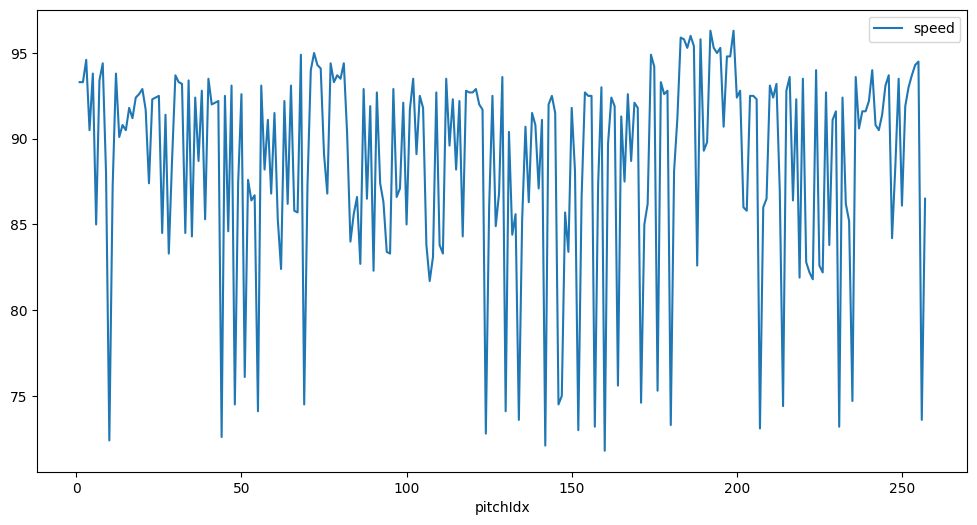

In [9]:
lines = pitch_df.plot(x="pitchIdx",y="speed", figsize=[12,6])

<Axes: xlabel='pitchIdx', ylabel='speed'>

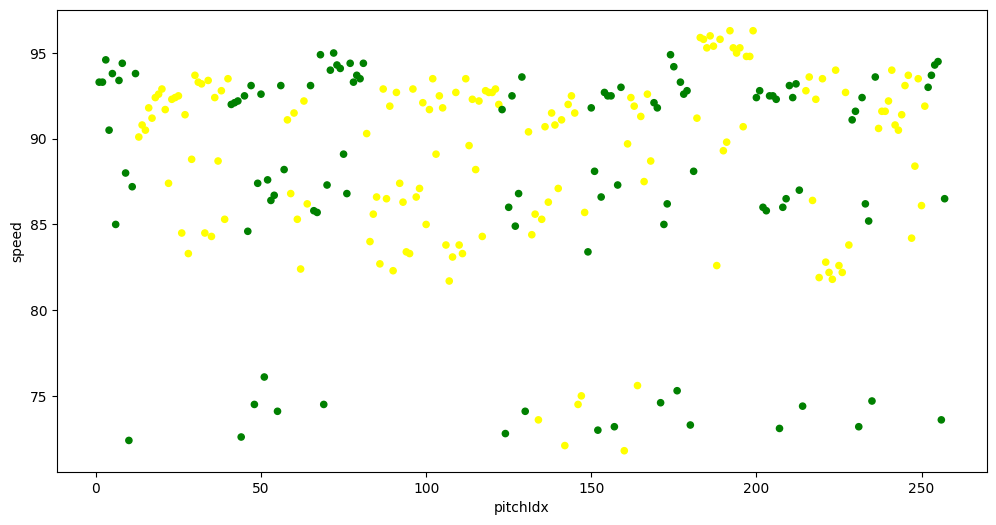

In [10]:
color = ['green' if f=='top' else 'yellow' for f in pitch_df['frame'].tolist()]
pitch_df.plot(kind='scatter',x="pitchIdx", y='speed',color=color,figsize=[12,6])

### Select operations from the dataframe

In [11]:
pitch_df[2:8] # non-inclusive range

,pitchIdx,inning,frame,ab,abIdx,batter,stand,speed,pitchtype,px,pz,szTop,szBottom,des
3,3,1,top,1,3,Corey Dickerson,L,94.6,4-seam fb,-1.67,1.33,3.66,1.71,Ball
4,4,1,top,1,4,Corey Dickerson,L,90.5,slider,-2.00,0.36,3.53,1.58,Ball
5,5,1,top,1,5,Corey Dickerson,L,93.8,4-seam fb,-0.26,3.47,3.40,1.51,Foul
6,6,1,top,1,6,Corey Dickerson,L,85.0,slider,-0.28,3.33,3.48,1.61,Called Strike
7,7,1,top,2,1,Brandon Barnes,R,93.4,4-seam fb,0.05,2.59,3.53,1.60,"In play, out(s)"
8,8,1,top,3,1,Troy Tulowitzki,R,94.4,4-seam fb,0.03,1.09,3.64,1.59,Ball


In [12]:
pitch_df.loc[pitch_df['ab']=='10'] # match a column value

,pitchIdx,inning,frame,ab,abIdx,batter,stand,speed,pitchtype,px,pz,szTop,szBottom,des
41,41,2,top,10,1,Wilin Rosario,R,92.0,4-seam fb,0.03,3.89,3.37,1.6,Ball
42,42,2,top,10,2,Wilin Rosario,R,92.1,4-seam fb,-0.34,3.38,3.37,1.6,Foul
43,43,2,top,10,3,Wilin Rosario,R,92.2,4-seam fb,-0.64,2.46,3.37,1.6,Foul
44,44,2,top,10,4,Wilin Rosario,R,72.6,curveball,0.54,2.91,3.37,1.6,Called Strike


In [13]:
pitch_df.loc[pitch_df['batter']=='Matt Kemp']

,pitchIdx,inning,frame,ab,abIdx,batter,stand,speed,pitchtype,px,pz,szTop,szBottom,des
34,34,1,bottom,8,1,Matt Kemp,R,93.4,4-seam fb,-0.86,2.20,3.47,1.74,Ball
35,35,1,bottom,8,2,Matt Kemp,R,84.3,fb-splitter,0.14,2.00,3.51,1.81,Called Strike
36,36,1,bottom,8,3,Matt Kemp,R,92.4,4-seam fb,-1.95,2.50,3.51,1.91,Ball
37,37,1,bottom,8,4,Matt Kemp,R,88.7,fb-cutter,-1.29,0.75,3.58,1.88,Ball In Dirt
38,38,1,bottom,8,5,Matt Kemp,R,92.8,4-seam fb,-0.14,2.58,3.58,1.77,Foul
39,39,1,bottom,8,6,Matt Kemp,R,85.3,fb-splitter,0.61,3.02,3.58,1.77,"In play, run(s)"
102,102,3,bottom,23,1,Matt Kemp,R,93.5,4-seam fb,-0.65,3.06,3.58,1.77,Foul
103,103,3,bottom,23,2,Matt Kemp,R,89.1,fb-cutter,-0.52,2.76,3.58,1.77,Foul
104,104,3,bottom,23,3,Matt Kemp,R,92.5,4-seam fb,-0.99,2.93,3.58,1.77,"In play, run(s)"
145,145,4,bottom,35,1,Matt Kemp,R,91.5,4-seam fb,-0.34,2.25,3.58,1.77,Called Strike


(-2.0, 2.0)

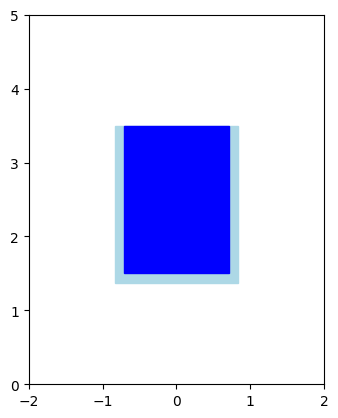

In [14]:
import matplotlib.pyplot as plot
import matplotlib.patches as patches
%matplotlib inline

fig1 = plot.figure()
ax1 = fig1.add_subplot(111,aspect='equal')

platewidthInFeet = 17 / 12 # plate is 17 inches wide
expandedPlateInFeet = 20 / 12 # add ball width (half on each side)
szHeightInFeet = 3.5 - 1.5
ballInFeet = 3 / 12
halfBallInFeet = ballInFeet / 2

#draw the expanded zone
outer_anchor = (-expandedPlateInFeet/2, 1.5 - halfBallInFeet)
outer_strike_zone_width = expandedPlateInFeet
outer_strike_zone_height = szHeightInFeet + halfBallInFeet
outer_strike_zone = patches.Rectangle(outer_anchor,
                                outer_strike_zone_width,
                                outer_strike_zone_height,
                                color='lightblue')

#draw the strict zone
inner_anchor = (-platewidthInFeet/2 ,1.5)
inner_strike_zone_width = platewidthInFeet
inner_strike_zone_height = szHeightInFeet
inner_strike_zone = patches.Rectangle(inner_anchor,
                                inner_strike_zone_width,
                                inner_strike_zone_height,
                                color='blue')

ax1.add_patch(outer_strike_zone)
ax1.add_patch(inner_strike_zone)
plot.ylim(0,5)
plot.xlim(-2,2)

### Kershaw Called Balls and Strikes (4 plots)

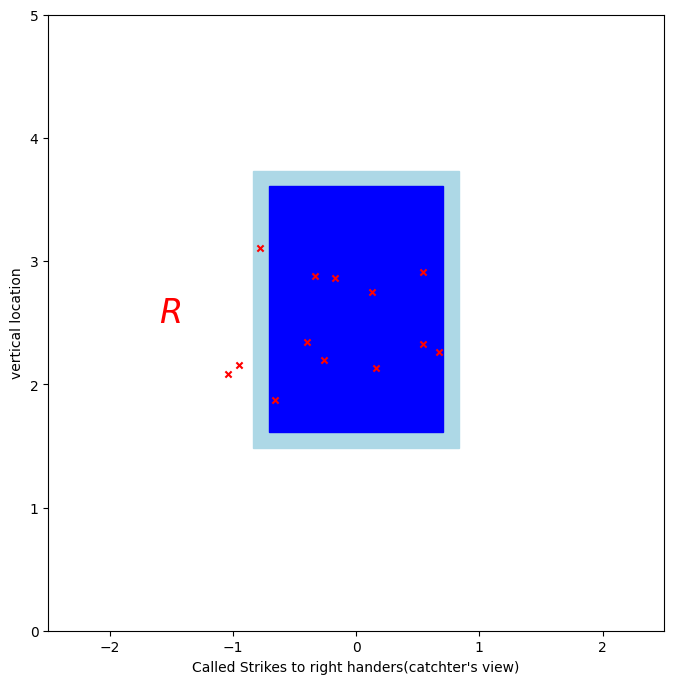

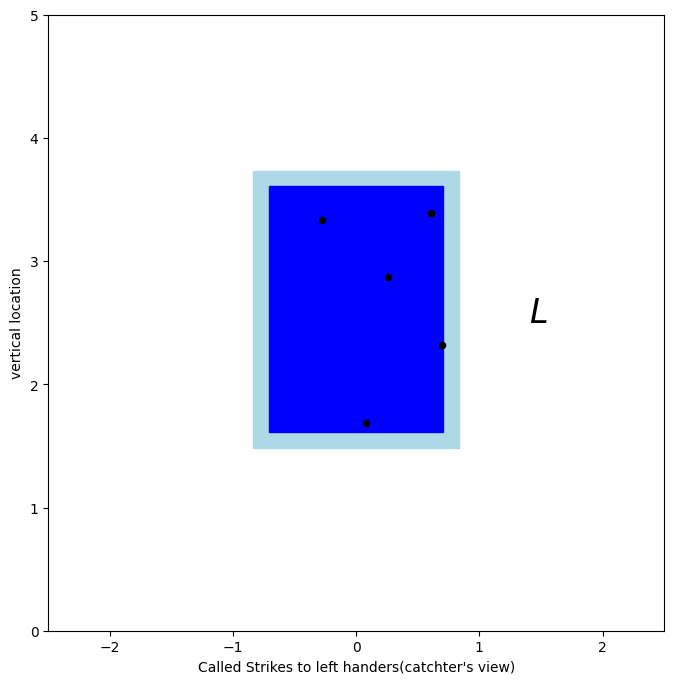

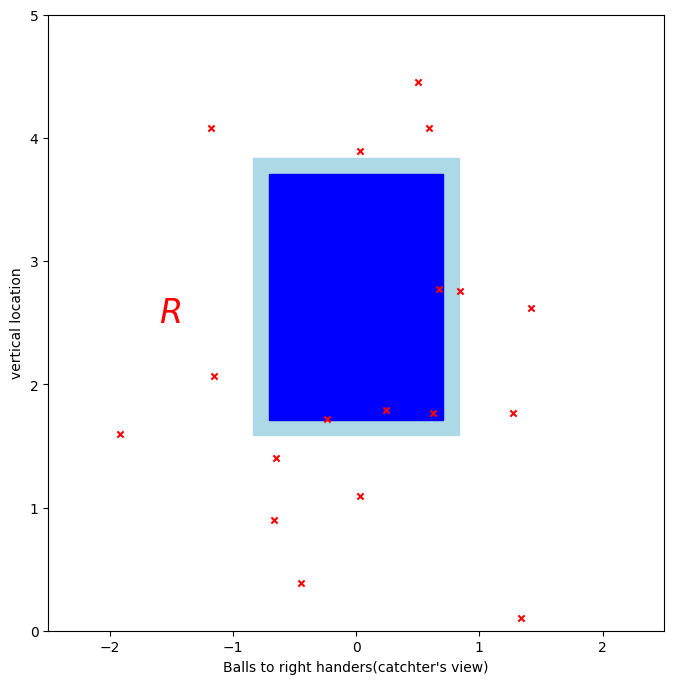

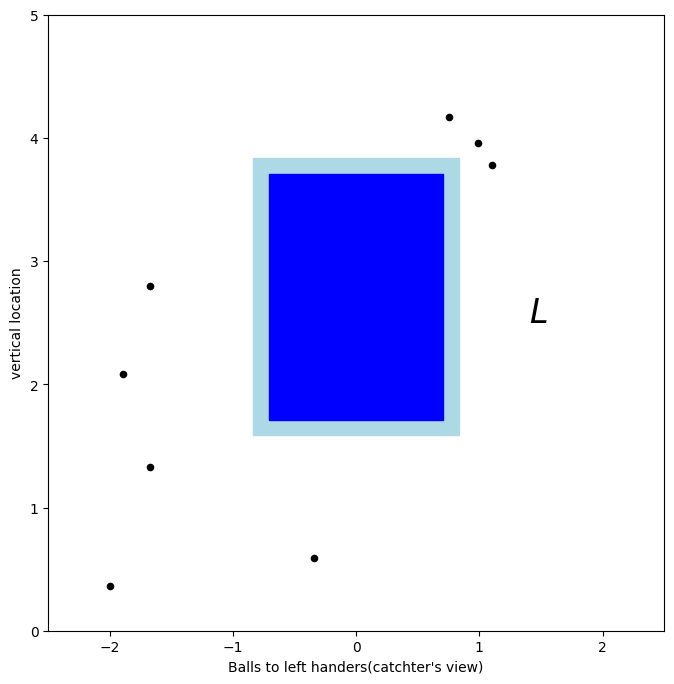

In [15]:
pitchCalls = ['Called Strike','Ball']
sides = ['R','L']
colors = {'R':'red', 'L':'black'}
markers = {'R':'x','L':'o'} #markers on plot
for pitchCall in pitchCalls:
    for sidename in sides:
        # pick out kershaw's pitches
        df = pitch_df.loc[pitch_df['des']==pitchCall].loc[pitch_df['frame']=='top']
        mark = markers[sidename]
        color = colors[sidename]
        df_side = df.loc[pitch_df['stand']==sidename]
        ax1 = df_side.plot(
            kind='scatter',
            x='px',
            y='pz',
            marker=mark,
            color=color, 
            figsize=[8,8], 
            ylim=[0,4],
            xlim=[-2,2]
        )
        if sidename == 'R':
            xcoord = -1.6 #position for label
            handers = "right handers"
        else:
            xcoord = 1.4 #position for label
            handers = "left handers"
        txtbatter = ax1.text(
            xcoord,
            2.5,
            sidename,
            style='italic',
            fontsize=24,
            color=color
        )
        
        platewidthInFeet = 17 / 12 #17 inches
        expandedPlateInFeet = 20 / 12 # adds 3inch ball, half each side
        szTop = df["szTop"].iloc[0]
        szBottom = df["szBottom"].iloc[0]
        szHeightInFeet = 3.5 - 1.5 #difference in top and bottom
        ballInFeet = 3 / 12
        halfBallInFeet = ballInFeet / 2

        #draw the strict zone
        inner_anchor = (-platewidthInFeet/2, szBottom)
        inner_strike_zone_width = platewidthInFeet
        inner_strike_zone_height = szHeightInFeet
        inner_strike_zone = patches.Rectangle(inner_anchor,
                                        inner_strike_zone_width,
                                        inner_strike_zone_height,
                                        color='blue')


        
        #draw the expanded zone
        outer_anchor = (-expandedPlateInFeet/2, szBottom - halfBallInFeet)
        outer_strike_zone_width = expandedPlateInFeet
        outer_strike_zone_height = szHeightInFeet + ballInFeet
        outer_strike_zone = patches.Rectangle(outer_anchor,
                                        outer_strike_zone_width,
                                        outer_strike_zone_height,
                                        color='lightblue')


        outer_rect = ax1.add_patch(outer_strike_zone)
        inner_rect = ax1.add_patch(inner_strike_zone)
        outer_rect.zorder = -2
        inner_rect.zorder = -1
        
        ax1.set_xlabel(pitchCall + "s to " + handers + "(catchter's view)")
        ax1.set_ylabel('vertical location')
        ax1.set_aspect(aspect=1)
        plot.ylim(0,5)
        plot.xlim(-2.5,2.5)


### Dickerson AtBat #1

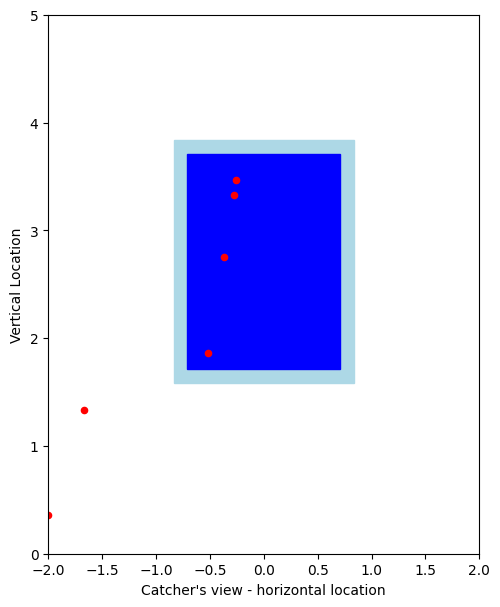

In [16]:
df = pitch_df.loc[pitch_df['ab']=='1'] # first ab of the game

ax1 = df.plot(kind='scatter',x='px',y='pz',color='red',figsize=[7,7],ylim=[0,5],xlim=[-2,2])
ax1.set_xlabel("Catcher's view - horizontal location")
ax1.set_ylabel("Vertical Location")
ax1.set_aspect(aspect=1)

# in another program, we might have a class that draw's the strike zone based on certain inputs, we can import as needed.
#draw the expanded zone
outer_anchor = (-expandedPlateInFeet/2, szBottom - halfBallInFeet)
outer_strike_zone_width = expandedPlateInFeet
outer_strike_zone_height = szHeightInFeet + ballInFeet
outer_strike_zone = patches.Rectangle(outer_anchor,
                                outer_strike_zone_width,
                                outer_strike_zone_height,
                                color='lightblue')

#draw the strict zone
inner_anchor = (-platewidthInFeet/2, szBottom)
inner_strike_zone_width = platewidthInFeet
inner_strike_zone_height = szHeightInFeet
inner_strike_zone = patches.Rectangle(inner_anchor,
                                inner_strike_zone_width,
                                inner_strike_zone_height,
                                color='blue')


outer_rect = ax1.add_patch(outer_strike_zone)
inner_rect = ax1.add_patch(inner_strike_zone)
outer_rect.zorder = -2
inner_rect.zorder = -1

### Label pitches

1 4-seam fb -0.52 1.86
2 4-seam fb -0.37 2.75
3 4-seam fb -1.67 1.33
4 slider -2.0 0.36
5 4-seam fb -0.26 3.47
6 slider -0.28 3.33


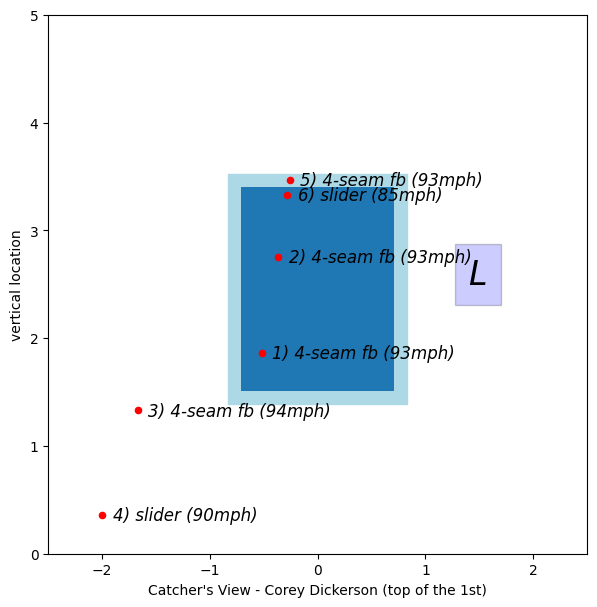

In [17]:
df = pitch_df.loc[pitch_df['ab']=='1']
#print(df)
stand = df['stand'].iloc[0]
batter = df['batter'].iloc[0]
inning = df['inning'].iloc[0]
frame = df["frame"].iloc[0]
suffix = "th"
suffix = "st" if inning == '1' else suffix
suffix = "nd" if inning == '2' else suffix
suffix = "rd" if inning == '3' else suffix

#print("Batter:" + batter)
ax1 = df.plot(kind='scatter', x='px', y='pz', color='red', figsize=[7,7], ylim=[0,4], xlim=[-2,2])
ax1.set_xlabel("Catcher's View - " + batter + " (" + frame + " of the " + inning + suffix + ")")
ax1.set_ylabel('vertical location')
ax1.set_aspect(aspect=1)
plot.ylim(0, 5)
plot.xlim(-2.5, 2.5)

platewidthInFeet = 17 / 12 # plate is 17 inches wide
expandedPlateInFeet = 20 / 12 # add ball width (half on each side)
szTop = df["szTop"].iloc[0]
szBottom = df["szBottom"].iloc[0]
szHeightInFeet = szTop - szBottom
# draw expanded zone: 3 inch ball (.25 ft) = 1.5 inches all the way around
outrect = ax1.add_patch(patches.Rectangle((expandedPlateInFeet/-2, szBottom - 0.125), expandedPlateInFeet, szHeightInFeet + 0.25, color='lightblue'))
rect = ax1.add_patch(patches.Rectangle((platewidthInFeet/-2, szBottom), platewidthInFeet, szHeightInFeet))
outrect.zorder=-2 
rect.zorder=-1 

if stand == 'R':
    standTextX = -1.5
else:
    standTextX = 1.4
tbatter = ax1.text(standTextX, 2.5, stand, style='italic', fontsize=24,
        bbox={'facecolor': 'blue', 'alpha': 0.2, 'pad': 10})

#label pitch points
ptypes = df["pitchtype"]
xcoords = df["px"]
ycoords = df["pz"]
speed = df["speed"]
abIdx = df["abIdx"]

for i, txt in enumerate(ptypes):
    print(abIdx.iloc[i], txt, xcoords.iloc[i], ycoords.iloc[i])
    txtDetail = str(abIdx.iloc[i]) + ") " + txt +  " (" + str(int(speed.iloc[i])) + "mph)"
    txt = ax1.text(xcoords.iloc[i]+.1, ycoords.iloc[i]-.05, txtDetail, style='italic', fontsize=12)

### Plot with Legend

   pitchIdx inning frame ab  abIdx           batter stand  speed  pitchtype   
1         1      1   top  1      1  Corey Dickerson     L   93.3  4-seam fb  \
2         2      1   top  1      2  Corey Dickerson     L   93.3  4-seam fb   
3         3      1   top  1      3  Corey Dickerson     L   94.6  4-seam fb   
4         4      1   top  1      4  Corey Dickerson     L   90.5     slider   
5         5      1   top  1      5  Corey Dickerson     L   93.8  4-seam fb   
6         6      1   top  1      6  Corey Dickerson     L   85.0     slider   

     px    pz  szTop  szBottom              des  
1 -0.52  1.86   3.40      1.51             Foul  
2 -0.37  2.75   3.40      1.51  Swinging Strike  
3 -1.67  1.33   3.66      1.71             Ball  
4 -2.00  0.36   3.53      1.58             Ball  
5 -0.26  3.47   3.40      1.51             Foul  
6 -0.28  3.33   3.48      1.61    Called Strike  
1 4-seam fb -0.52 1.86
2 4-seam fb -0.37 2.75
3 4-seam fb -1.67 1.33
4 slider -2.0 0.36
5 4-seam

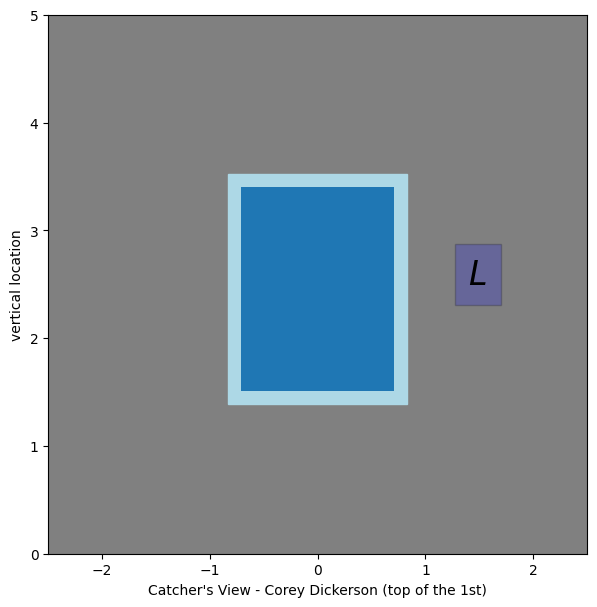

In [34]:
pitchColors = { "FA":"b", "FF":"red", "FT": "y", "FC": "k", "":"w", None: "violet",
                    "FS":"aqua", "SL":"white", "CH":"h","CU":"gold","KC":"tan",
                    "KN":"^","EP":"*", "UN":"X", "PO":"s", "SI":"_", "SF":"seagreen"
                    }
df = pitch_df.loc[pitch_df['ab']=='1']
print(df)
stand = df['stand'].iloc[0]
batter = df['batter'].iloc[0]
inning = df['inning'].iloc[0]
frame = df["frame"].iloc[0]
suffix = "th"
suffix = "st" if inning == '1' else suffix
suffix = "nd" if inning == '2' else suffix
suffix = "rd" if inning == '3' else suffix

availColors = ['b','r','y','k','w']
pitchesUsed = df['pitchtype'].unique()
abCount = len(df['speed'])
# print(abCount)
markerSize = [0] * abCount
colors = ['b'] * abCount
# print(colors)

# print(df['pitchtype'])
# print(df['speed'])
for i, sx in enumerate(df['speed'], start=1):
    thrownPitch = df['pitchtype'][i]
    for j, (k, v) in enumerate(pitchDictionary.items()):
        if thrownPitch == v:
            colors[i-1] = pitchColors[k]
            
# print(markerSize, colors, pitchesUsed)

ax1 = df.plot(kind='scatter', x='px', y='pz',  color=colors, s=markerSize, marker="o", figsize=[7,7], ylim=[0,4], xlim=[-2,2])
ax1.set_xlabel("Catcher's View - " + batter + " (" + frame + " of the " + inning + suffix + ")")
ax1.set_ylabel('vertical location')
ax1.set_aspect(aspect=1)
ax1.patch.set_facecolor("grey")
plot.ylim(0, 5)
plot.xlim(-2.5, 2.5)

platewidthInFeet = 17 / 12 # plate is 17 inches wide
expandedPlateInFeet = 20 / 12 # add ball width (half on each side)
szTop = df["szTop"].iloc[0]
szBottom = df["szBottom"].iloc[0]
szHeightInFeet = szTop - szBottom
# draw expanded zone: 3 inch ball (.25 ft) = 1.5 inches all the way around
outrect = ax1.add_patch(patches.Rectangle((expandedPlateInFeet/-2, szBottom - 0.125), expandedPlateInFeet, szHeightInFeet + 0.25, color='lightblue'))
rect = ax1.add_patch(patches.Rectangle((platewidthInFeet/-2, szBottom), platewidthInFeet, szHeightInFeet))
outrect.zorder=-2 
rect.zorder=-1 

if stand == 'R':
    standTextX = -1.5
else:
    standTextX = 1.4
tbatter = ax1.text(standTextX, 2.5, stand, style='italic', fontsize=24,
        bbox={'facecolor': 'blue', 'alpha': 0.2, 'pad': 10})

#label pitch points
ptypes = df["pitchtype"]
xcoords = df["px"]
ycoords = df["pz"]
speed = df["speed"]
abIdx = df["abIdx"]

for i, txt in enumerate(ptypes):
    print(abIdx.iloc[i], txt, xcoords.iloc[i], ycoords.iloc[i])